In [1]:
import numpy as np #numpy for math operation
import os
import utils
import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
import scipy.ndimage
# from time import time
from tqdm import tqdm
import cv2
from natsort import natsorted
# from pydicom import dcmread
import matplotlib.gridspec as gridspec
import h5py
data_path = "D:\\globus slate shared data Tankam Lab\\IR_card_standard_inter_registered"
average_LivCurve = True
fitting_method = "CPU"
frameSeparationTime = 0.001 #1ms frame to frame time interval
alivInitial  = 1 #initla guess for aliv parameter curve fitting
swiftInitial = 1 # initial guess for swiftness parameter curve fitting
bounds = (0, np.inf)
# save_dcm_pickle(data_path)

put everything in a scan in a pickle file 

In [3]:
scan_name = natsorted(os.listdir(data_path))[10]
dcm_name = natsorted(os.listdir(os.path.join(data_path, scan_name)))[0]

# ds = dcmread(os.path.join(data_path, scan_name, dcm_name))
# arr = ds.pixel_array
# plt.imshow(arr, cmap="gray")

In [4]:
with h5py.File(os.path.join(data_path, scan_name, f'{scan_name}.h5'), 'r') as handle:
    volume = np.array(handle["volume"])

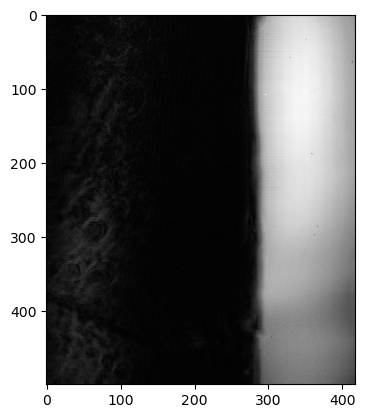

In [7]:
copy_volume = volume[:, 51, :].copy()
# copy_volume[264, :] = 1000
plt.imshow(copy_volume, cmap="gray")
# plt.yticks(np.arange(0, 1000, 50))# 

In [2]:
image_list = os.listdir(data_path)#list all images address in data_path
fourD_image_volume_complete = utils.load_nested_data_h5(data_path, 30, 49, 53, median_filter=3)#load all image volume and combine them in one 4D np array

100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


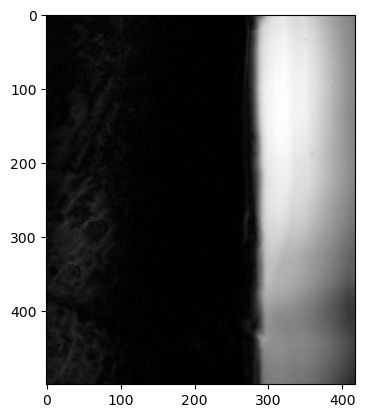

In [3]:
fourD_image = fourD_image_volume_complete
plt.imshow(fourD_image[4, :, 1, :], cmap="gray")

In [4]:
concatenate_set = utils.concatenate_scan_set(fourD_image)

In [5]:
blockRepeat = fourD_image.shape[0]
blockPerVolume = 1 #only 1 block is used in our protocal
bscanLocationPerBlock = fourD_image.shape[1] #the number of B-scan in one 3D volume

In [6]:
numLocation = bscanLocationPerBlock * blockPerVolume # Number of total B-scan

print('Processing: ' + data_path)

## OCT intensity
height = concatenate_set.shape[1]
width = concatenate_set.shape[2]

aliv = np.zeros((numLocation, height, width))
swift = np.zeros((numLocation, height, width))
oct_db = np.zeros((numLocation, height, width))

Processing: D:\globus slate shared data Tankam Lab\IR_card_standard_inter_registered


In [ ]:
# floc = 4
# sparseSequence, timePoints, frameindex = utils.makeSparseDataFromRasterRepeat(concatenate_set, bscanLocationPerBlock, blockRepeat, floc)

In [ ]:
# print(frameindex)

range(4, 200, 10)


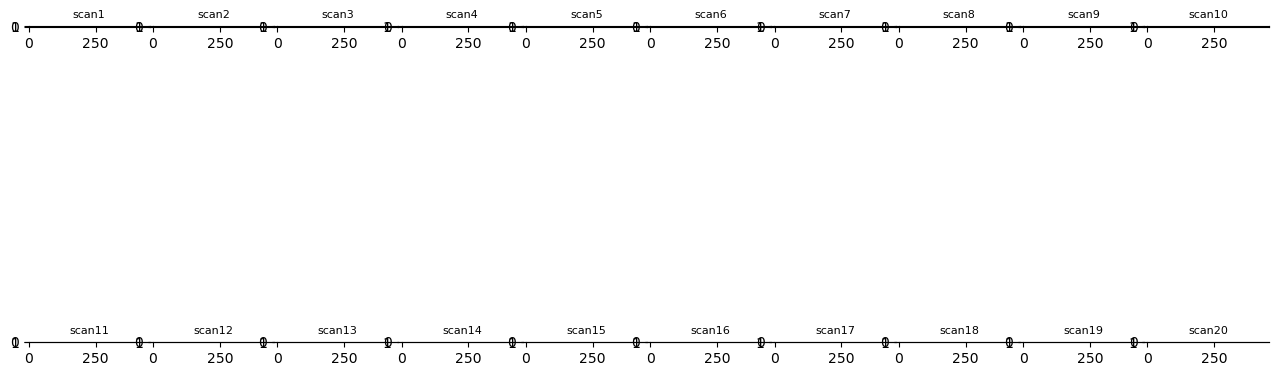

In [ ]:

# plt.figure(figsize=(16, 8))
# gs1 = gridspec.GridSpec(2, 10)
# gs1.update(wspace = 0.025, hspace = 0.05)

# framenum=0
# for i in range(20):
#     ax1 = plt.subplot(gs1[i])
#     plt.axis('on')
#     ax1.imshow(sparseSequence[framenum, :, :], cmap="gray")
#     plt.title(f'scan{framenum+1}', fontsize = 8)
#     ax1.set_aspect('equal')
#     framenum = framenum+1
# plt.show()


In [ ]:
# if floc == 0: #for save VLIV array
#     VLIV_save = np.zeros((numLocation, timePoints.shape[0]-1, height, width))

In [ ]:
# maxTimeWidth = np.nan
# OctSequence = sparseSequence
# timePoints = np.asarray(timePoints)
# A = np.ones((1,timePoints.shape[0]))
# B = np.asarray(timePoints.reshape(timePoints.shape[0],1))
# timePointMatrix = np.transpose(A*B) - A*B
# timePointMatrix[timePointMatrix<0] = 0.
# possibleMtw = np.unique(timePointMatrix)
# possibleMtw = possibleMtw[possibleMtw != 0.] # to remove the elemnt of 0.0

# # Reduce the time-region to be computed to meet with "maxTimeWidth"
# if np.isnan(maxTimeWidth):
#     pass
# else:
#     maxTimeWidth = np.asarray(maxTimeWidth)
#     possibleMtw = possibleMtw[possibleMtw <= maxTimeWidth] 

# logSparseSequence = 10*np.log10(OctSequence + 1e-8)
# logSparseSequence = np.asarray(logSparseSequence)             # for cupy computation
# VLIV = np.zeros((possibleMtw.shape[0], logSparseSequence.shape[1], logSparseSequence.shape[2]))

# # variance of variance
# VoV = np.zeros((possibleMtw.shape[0], logSparseSequence.shape[1], logSparseSequence.shape[2]))

In [ ]:
# possibleMtw

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.,
       120., 130., 140.])

In [ ]:
# i = 0        
# for mtw in possibleMtw[0:2]:
#     A = np.ones((1,timePoints.shape[0]))
#     B = timePoints.reshape(timePoints.shape[0],1)
#     timePointMatrix = np.transpose(A*B) - A*B
#     validTimePointMatrix = (timePointMatrix <= mtw)*(timePointMatrix >= 0)

#     ##---------------------
#     ## Let's rewirte later as not to use for-loop
#     ##---------------------    
#     trueMtw = np.zeros(validTimePointMatrix.shape[0])
#     for j in range (0,validTimePointMatrix.shape[0]):
#         X = validTimePointMatrix[j,:]
#         X = timePoints[X]
#         Y = np.max(X) - np.min(X)
#         trueMtw[j] = Y
    
#     validTimePointMatrix = validTimePointMatrix[(trueMtw >= mtw),:]

#     # validTimePointMatrix = seekDataForMaxTimeWindow(timePoints, mtw)
#     validTimePointMatrix = np.asarray(validTimePointMatrix)    # for cupy computation 
    
#     # cupy compute
#     for m in range(0, validTimePointMatrix.shape[0]):
#         VLIV[i] = VLIV[i] + np.nanvar(logSparseSequence[validTimePointMatrix[m,:]],axis=0)
#         # newly added for LIV for each subset 


#     VLIV[i] = VLIV[i] / (validTimePointMatrix.shape[0])
    
#     # variance of variance (VoV) at a single time window (2D array)
    
#     i = i+1

In [ ]:
# validTimePointMatrix


array([[ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False,  True,  True,  True, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False,  True,  True,  True, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False,  True,  True,  True, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False,  True,  True,
         True, False, False, False, False, False],
       [False, False, Fa

In [7]:
for floc in tqdm(range(0,numLocation), position=0, leave=True):

    # print(floc)
    sparseSequence, timePoints, frameindex = utils.makeSparseDataFromRasterRepeat(concatenate_set, bscanLocationPerBlock, blockRepeat, floc)


    if floc == 0: #for save VLIV array
        VLIV_save = np.zeros((numLocation, timePoints.shape[0]-1, height, width))
    
    oct_db[floc] = 10*np.log10(np.nanmean(sparseSequence + 1e-8, axis=0))
    
    ## Compute VLIV
    VLIV , possibleMtw , VoV = utils.computeVLIV(sparseSequence, timePoints, maxTimeWidth =  np.nan, compute_VoV = False)
    
    ## Average LIV curve
    if average_LivCurve == True:
        twIdx = 0
        for twIdx in range(0, VLIV.shape[0]):                
            VLIV[twIdx,:,:] = cv2.blur(VLIV[twIdx,:,:], (3,3))
            twIdx = twIdx + 1

    
    if fitting_method == 'CPU':
        mag, tau = utils.vlivCPUFitExp(VLIV, possibleMtw, frameSeparationTime, alivInitial, swiftInitial, bounds, use_constraint = False)

    aliv[floc] = mag ## aLIV
    swift[floc] = tau ## inverse Swiftness
    VLIV_save[floc,:,:,:] = VLIV ## LIV curve (VLIV)

  0%|          | 0/500 [00:00<?, ?it/s]d:\xiaoliu_onedrive\OneDrive - Indiana University\lab\Dynamic_OCT\dynamic_oct_python\utils.py:394: OptimizeWarning: Covariance of the parameters could not be estimated
  popt = curve_fit(LIV_fun,
d:\xiaoliu_onedrive\OneDrive - Indiana University\lab\Dynamic_OCT\dynamic_oct_python\utils.py:136: RuntimeWarning: overflow encountered in exp
  return np.absolute(a) * (1 - np.exp(-Tw / tau))
 21%|██        | 106/500 [01:28<06:13,  1.06it/s]d:\xiaoliu_onedrive\OneDrive - Indiana University\lab\Dynamic_OCT\dynamic_oct_python\utils.py:136: RuntimeWarning: overflow encountered in multiply
  return np.absolute(a) * (1 - np.exp(-Tw / tau))
100%|██████████| 500/500 [07:36<00:00,  1.09it/s]


In [8]:
sum(np.isnan(np.ndarray.flatten(aliv)))

np.int64(0)

In [9]:
##remove NaN values in the aliv and swift
# aliv_filter = scipy.ndimage.generic_filter(aliv, np.nanmean, size = 2, mode="nearest")
# swift_filter = scipy.ndimage.generic_filter(swift, np.nanmean, size = 2, mode="nearest")
swift = 1 / swift

In [19]:
with open(os.path.join(data_path, "swift_Yusuno.npy"), "wb") as f:
    np.save(f, swift)

with open(os.path.join(data_path, "aliv_Yusuno.npy"), "wb") as f:
    np.save(f, aliv)

with open(os.path.join(data_path, "VLIV.npy"), "wb") as f:
    np.save(f, VLIV_save)

In [6]:
with open(os.path.join(data_path, "swift_Yusuno.npy"), "r") as f:
    swift = np.load(f)

with open(os.path.join(data_path, "aliv_Yusuno.npy"), "r") as f:
    aliv = np.load(f)

EOFError: No data left in file

In [9]:
np.percentile(swift[:, 0:2, :], 95)

np.float64(1.5587013863314556)

add color to swift and alive in my way

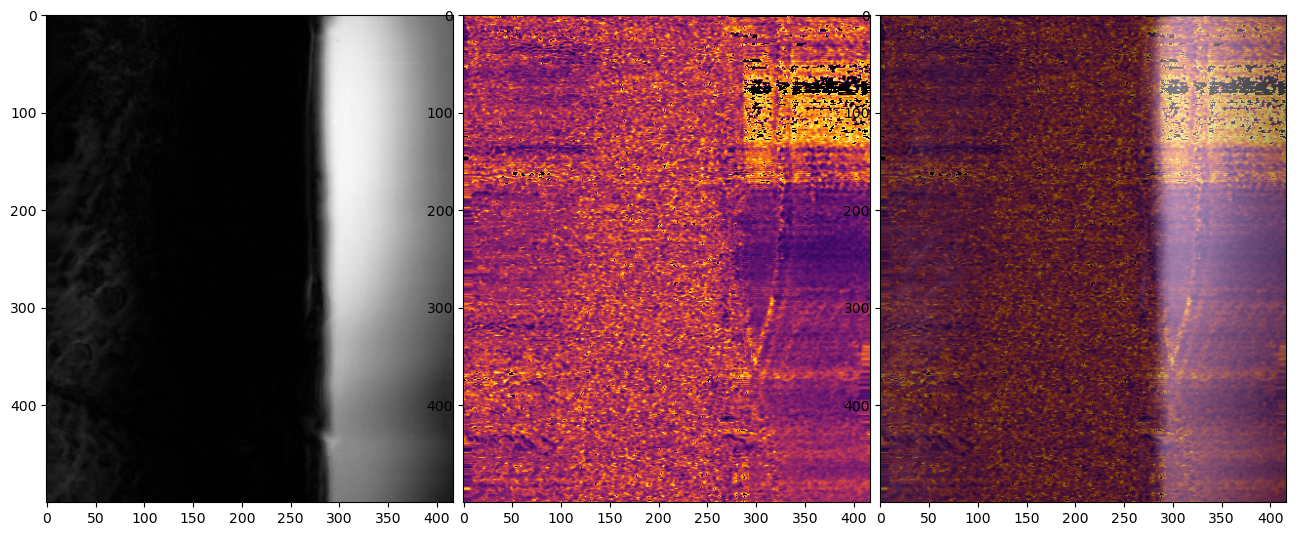

In [10]:
slice_index = 0
swift_slice = swift[:, slice_index, :]
swift_slice[swift_slice > np.percentile(swift_slice, 98)] = 0
swift_normalized = cv2.normalize(swift_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.float64)
fourD_normalized = cv2.normalize(fourD_image[10, :, slice_index, :], None, 0, 255, cv2.NORM_MINMAX).astype(np.float64)

plt.figure(figsize=(16, 8))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace = 0.025, hspace = 0.05)

ax1 = plt.subplot(gs1[0])
plt.axis('on')
ax1.imshow(fourD_normalized, cmap="gray")
ax1.set_aspect('equal')
ax2 = plt.subplot(gs1[1])
plt.axis('on')
ax2.imshow(swift_normalized, cmap="inferno")
ax2.set_aspect('equal')
ax3 = plt.subplot(gs1[2])
plt.axis('on')
ax3.imshow(fourD_normalized, cmap="gray")
ax3.imshow(swift_normalized, cmap="inferno", alpha=0.5)
ax1.set_aspect('equal')
plt.show()

add color to swift and aliv use Dr Yusuno's way

In [11]:
np.max(oct_db)

np.float64(27.026495370573663)

In [12]:
# octRange = (np.min(oct_db), np.max(oct_db))
octRange = (10, 40)
alivRange = (0, 10)
swiftRange = (0, 3)
mod_swift = np.copy(swift)
mod_swift[mod_swift > np.percentile(mod_swift, 95)] = 0
aliv_rgb = utils.generate_RgbImage(doct = aliv, dbInt = oct_db, doctRange = alivRange, octRange = octRange, scale=0.33)
swift_rgb = utils.generate_RgbImage(doct = swift, dbInt = oct_db, doctRange = swiftRange, octRange = octRange, scale=0.33)

In [52]:
np.max(oct_db)

np.float64(27.026495370573663)

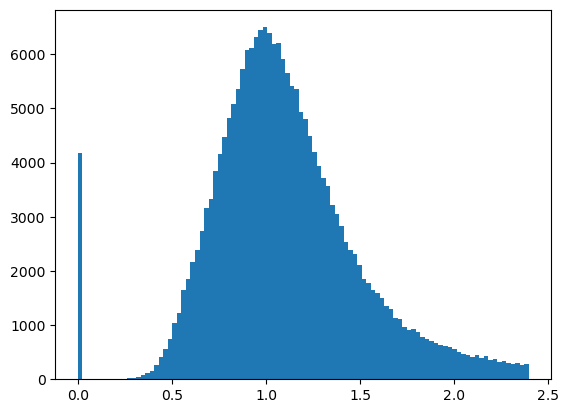

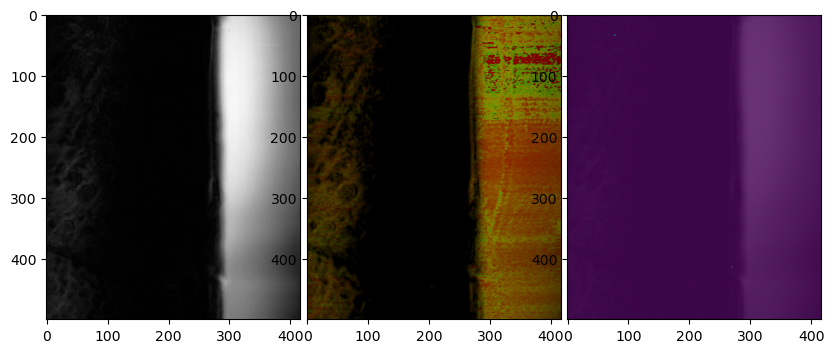

In [14]:
swift_rgb_slice = swift_rgb[:, slice_index, :]
plt.hist(np.ndarray.flatten(swift_slice), bins=100)
slice_mask = np.copy(swift_slice)
slice_mask[np.logical_or(swift_slice<=0.1, swift_slice >=0.15)] = 0
slice_mask[np.logical_and(swift_slice>0.1, swift_slice<0.15)] = 0.3
plt.figure(figsize=(10, 10))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace = 0.025, hspace = 0.01)

ax1 = plt.subplot(gs1[0])
plt.axis('on')
ax1.imshow(fourD_normalized, cmap="gray")
ax1.set_aspect('equal')
ax2 = plt.subplot(gs1[1])
plt.axis('on')
ax2.imshow(swift_rgb_slice)
ax2.set_aspect('equal')
ax3 = plt.subplot(gs1[2])
plt.axis('on')
ax3.imshow(fourD_normalized, cmap="gray", alpha=0.9)
slice_normalized = cv2.normalize(slice_mask, None, 0, 255, cv2.NORM_MINMAX).astype(np.float64)
ax3.imshow(slice_normalized, alpha=0.8)
ax3.set_aspect('equal')
plt.show()

In [26]:
aliv.shape

(500, 4, 417)

check the LIV curve with fitted LIV curve

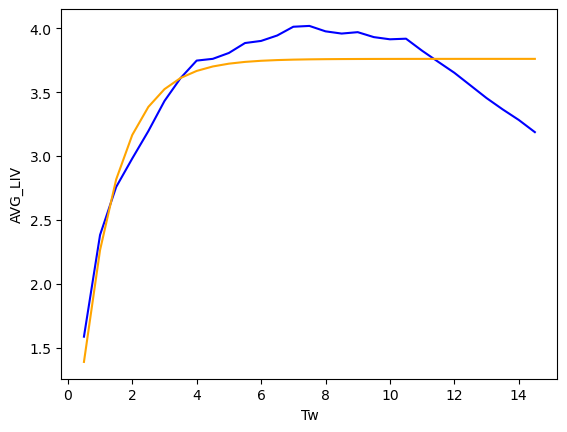

In [51]:
cord = [250, 2, 59]#coordinate
time = possibleMtw
mag = aliv[cord[0], cord[1], cord[2]]
tau = 1 / swift[cord[0], cord[1], cord[2]]
fit_LIV = utils.LIV_fun(possibleMtw*frameSeparationTime, mag, tau)
plt.plot(possibleMtw*frameSeparationTime, VLIV_save[cord[0], :, cord[1], cord[2]], color = "blue")
plt.plot(possibleMtw*frameSeparationTime, fit_LIV, color = "orange")
plt.xlabel("Tw")
plt.ylabel("AVG_LIV")
plt.show()